<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 5 - Vanishing & Exploding Gradient 
**Nome:**

**Numero Usp:**









______________



Nessa lista exploraremos alguns problemas que podemos encontrar ao treinarmos uma rede recorrente. Esses problemas não são únicos das redes recorrentes, qualquer rede profunda pode sofrer de vanishing e exploding gradient mas as redes recorrentes são especialmente instaveis devido a utilização da mesma matriz de pesos repetidas vezes.

Começaremos explorando o exploding gradient e alguns de seus sintomas, em seguida utilizaremos gradient cliping para combate-lo. 
Por fim estudaremos uma rede que sofre de vanishing gradient e utilizaremos o [TensorBoard](??) para visualizar os gradientes e pesos da rede para entender melhor sua dinâmica. Exploraremos tambem algumas maneiras de combater o vanishing gradient e como elas alteram a dinâmica da rede através do TensorBoard.



Para essa aula é necessario instalar o TensorBoard




In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%load_ext tensorboard

from sklearn.datasets import make_circles
from numpy import where
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomUniform





from utils import ExtendedTensorBoard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard




# Exploding

Para essa parte da lista nós preparamos uma rede, note como a *loss* cresce exponencialmente até virar infinita e logo em seguida NaN. Esse é um sintoma classico de exploding gradient. O gradiente está tão elevado que a cada etapa de backpropagation o passo de atualização dos parametros leva a um aumento na *loss* e isso segue crescendo até que exploda. 


In [12]:
def f1(x):
    return 5+ 10*x

xs = [x for x in range(100)]
ys = [f1(x) for x in range(100)]


In [13]:
opt = keras.optimizers.SGD()
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer=opt, loss="mean_squared_error")
model.fit(xs,ys,epochs=400)


Epoch 1/400
4/4 [==============================] - 0s 587us/step - loss: 632637878173696.0000
Epoch 2/400
4/4 [==============================] - 0s 528us/step - loss: 134113356945836639168042631168.0000
Epoch 3/400
4/4 [==============================] - 0s 941us/step - loss: inf                               
Epoch 4/400
4/4 [==============================] - 0s 1ms/step - loss: inf
Epoch 5/400
4/4 [==============================] - 0s 567us/step - loss: inf
Epoch 6/400
4/4 [==============================] - 0s 751us/step - loss: nan
Epoch 7/400
4/4 [==============================] - 0s 827us/step - loss: nan
Epoch 8/400
4/4 [==============================] - 0s 786us/step - loss: nan
Epoch 9/400
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 10/400
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 11/400
4/4 [==============================] - 0s 704us/step - loss: nan
Epoch 12/400
4/4 [==============================] - 0s 1ms/step - loss: nan
E

## Gradient Cliping
## <font color='blue'>Questão 1 </font>


Utilizando a mesma arquitetura, realize gradient clipping no otimizador para contornar o problema de exploding gradient, compile e treine seu novo modelo.
Você pode usar tanto o parametro `clipvalue` quanto `clipnorm` desde que sua rede consiga minimizar a loss.


In [14]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])

model.compile(optimizer=SGD(lr=0.01, clipvalue=1),loss="mean_squared_error")
model.fit(xs,ys,epochs=400)


Epoch 1/400
4/4 [==============================] - 0s 638us/step - loss: 269413.7812
Epoch 2/400
4/4 [==============================] - 0s 687us/step - loss: 267028.6562
Epoch 3/400
4/4 [==============================] - 0s 935us/step - loss: 264592.9688
Epoch 4/400
4/4 [==============================] - 0s 890us/step - loss: 262228.8125
Epoch 5/400
4/4 [==============================] - 0s 684us/step - loss: 259807.7656
Epoch 6/400
4/4 [==============================] - 0s 757us/step - loss: 257464.6875
Epoch 7/400
4/4 [==============================] - 0s 730us/step - loss: 255092.2812
Epoch 8/400
4/4 [==============================] - 0s 754us/step - loss: 252739.0000
Epoch 9/400
4/4 [==============================] - 0s 578us/step - loss: 250411.8125
Epoch 10/400
4/4 [==============================] - 0s 1ms/step - loss: 248141.4531
Epoch 11/400
4/4 [==============================] - 0s 1ms/step - loss: 245725.1406
Epoch 12/400
4/4 [==============================] - 0s 848us/step -

________________________



# Vanishing

Lidar com Vanishing Gradient é muito mais desafiador do que com exploding gradient. Não é trivial determinar se o baixo desempenho de sua rede é causado por vanishing gradient uma vez que seus sintomas são relativamente genericos e ele pode ser apenas mais um dos fatores que prejudicam seu desempenho. Além disso não existe uma solução geral e definitiva como o gradient cliping em casos de explosão do gradiente.

Preparamos algumas redes para poder explorar um caso mais simples de vanishing gradient e também uma possivel solução. Começamos gerando um dataset simples de classificação e treinamos uma rede rasa que obtem uma boa performance. 
Ao aprofundarmos essa rede podemos notar que sua performance cai drasticamente se tornando quase tão eficiente quanto jogar uma moeda para chutar a classe do ponto, ela nem mesmo é capaz de overfittar os dados. Utilizaremos o TensorBoard para explorar os gradientes dessa rede mais profunda e tentar analisar essa queda de performance. Em seguida utilizaremos uma nova forma de inicialização dos pesos da rede para tentar recuperar nossa performance e novamente inspecionar os seus gradientes para tentar ganhar algum insight do que está acontecendo dentro dela.

___________

## TensorBoard e Callbacks

O TensorBoard é uma ferramenta de monitoramento e visualização de redes neurais. Nós o utilizaremos para visualizar os gradientes de nossa rede e poder entender mais afundo o que está causando nosso fraco desempenho. Para mais informações sobre o TensorBoard recomendamos este [guia da documentação oficial](https://www.tensorflow.org/tensorboard/get_started). O TensorBoard pode ser iniciado como parte do notebook usando a "magica"  `%load_ext tensorboard` para carrega-lo e `%tensorboard --logdir logs/` para inicia-lo. Outra maneira de utiliza-lo é independente pelo terminal a partir dos logs salvos na pasta `log_dir` com o comando `tensorboard --logdir="logs/"`. 

Para utilizar o TensorBoard nós utilizamos um callback ao treinar nossa rede. 

[Callbacks](https://keras.io/api/callbacks/#tensorboard) são objetos do Keras capazes de realizar ações em diferentes etapas do treinamento, como a cada final de epoch ou antes de cada mini-batch. Três exemplos interessates de callbacks são o [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) que te permite encerrar o treinamento de sua rede quando você atinge uma performance minima desejada, o [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) que lhe permite criar checkpoints do seu modelo para poder reiniciar o treinamento sem perder todo seu progresso em caso de algum problema (como seus gradientes explodindo por exemplo) e o [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/) que lhe permite alterar o learning rate do seu otimizador conforme a epoch de treinamento.

O TensorBoard possui um callback que nos permite monitorar o desempenho e parâmetros de nosso modelo ao longo do treinamento, porém para guardar os gradientes da rede necessitamos expandir e adaptar o [callback padrão do TensorBoard](https://keras.io/api/callbacks/tensorboard/). 

Nós ja implementamos para vocês uma extensão desse callback no arquivo `utils.py`.
Para usar este callback basta importa-lo e declara-lo da seguinte maneira:


```python
from utils import ExtendedTensorBoard
log_dir = "logs/"
tensorboard_callback = ExtendedTensorBoard(x=dados_treino, y=labels_treino,log_dir=log_dir,histogram_freq=1)
```
________________

## Definindo nossos dados
Primeiro definiremos um toy dataset bem simples que utilizaremos para nossos modelos e uma função auxiliar para facilitar a comparação de nossos modelos.


Esses dados e redes foram inspirados e adaptados [deste post](https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/).


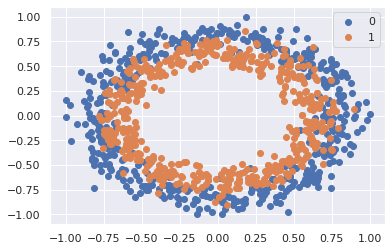

In [15]:
# gera dataset de classificação 
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

# escala input para [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# plota visualização do dataset
for i in range(2):
    samples_ix = where(y == i)
    plt.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
plt.legend()
plt.show()

# separa em teste e treino
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [16]:
def run_model(model,log_to_tb= False ,trainX=trainX,trainy=trainy,testX=testX,testy=testy):
    """
    Função auxiliar que recebe um modelo e realiza seu treinamento e avaliação no dataset.
    """
    model.summary()
    
    # compila modelo
    opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    #Cria log do modelo pra visualizarmos no TensorBoard se a flag estiver ligada
    callbacks = None
    if log_to_tb==True:
        log_dir = "logs/" + model.name
        callbacks=[ExtendedTensorBoard(x=trainX, y=trainy,log_dir=log_dir,histogram_freq=1)]
    

    # fit modelo
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0, callbacks=callbacks)

    # avalia modelo
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print("\n")
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


    # plota acurácia/training history
    plt.ylim(0, 1)
    plt.title("Acurácia "+ model.name)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    

In [17]:
tf.__version__

'2.2.1'

## Rede rasa
Aqui temos uma rede rasa com apenas uma camada oculta e uma de output, note que ela é capaz de atingir uma performance razoavel após 300 epochs.

Nos estamos utilizando um inicializador diferente do padrão para os pesos da camada, ele retirar os pesos iniciais a partir de uma distribuição uniforme no intervalo [0,1]. 

Model: "modelo_raso"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
raso_1 (Dense)               (None, 5)                 15        
_________________________________________________________________
raso_output (Dense)          (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Train: 0.818, Test: 0.806


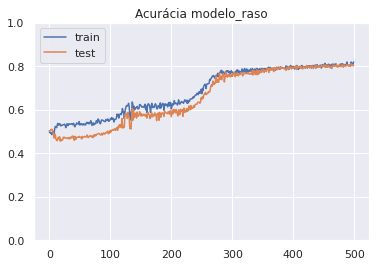

In [18]:
#define modelo raso
init = RandomUniform(minval=0, maxval=1)

model = keras.Sequential(name="modelo_raso")
model.add(keras.layers.Dense(5,
                       input_dim=2,
                       activation="tanh",
                       kernel_initializer=init,
                       name="raso_1"))
model.add(keras.layers.Dense(1,
                       activation='sigmoid',
                       kernel_initializer=init,
                       name="raso_output"))


run_model(model)

## Rede funda

Agora tornaremos nossa rede mais funda com 5 camadas ocultas e uma de output, note como a performance cai drasticamente e se torna próxima a um chute aleatório. Embora o modelo seja mais complexo e poderoso nós não conseguimos treina-lo.

Model: "modelo_fundo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
funda_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
funda_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
funda_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
funda_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
funda_5 (Dense)              (None, 5)                 30        
_________________________________________________________________
funda_output (Dense)         (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
________________________________________________________

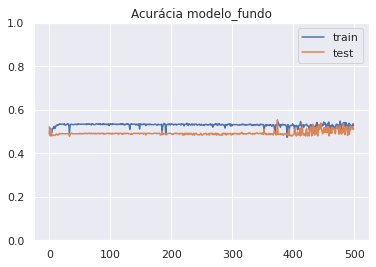

In [19]:
# define modelo mais fundo
init = RandomUniform(minval=0, maxval=1)

model = Sequential(name="modelo_fundo")
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init,name="funda_1"))
model.add(Dense(5, activation='tanh', kernel_initializer=init,name="funda_2"))
model.add(Dense(5, activation='tanh', kernel_initializer=init,name="funda_3"))
model.add(Dense(5, activation='tanh', kernel_initializer=init,name="funda_4"))
model.add(Dense(5, activation='tanh', kernel_initializer=init,name="funda_5"))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init,name="funda_output"))


run_model(model,log_to_tb=True)

### Utilizando inicialização de Xavier Glorot

Agora utilizaremos uma técnica de combate ao vanishing gradient, utilizaremos outro inicializador para os pesos da rede. O [inicializador de Xavier Glorot](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) é o inicializador default de algumas camadas do keras como a camada densa que utilizamos. 



Model: "modelo_xavier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xavier_1 (Dense)             (None, 5)                 15        
_________________________________________________________________
xavier_2 (Dense)             (None, 5)                 30        
_________________________________________________________________
xavier_3 (Dense)             (None, 5)                 30        
_________________________________________________________________
xavier_4 (Dense)             (None, 5)                 30        
_________________________________________________________________
xavier_5 (Dense)             (None, 5)                 30        
_________________________________________________________________
xavier_output (Dense)        (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_______________________________________________________

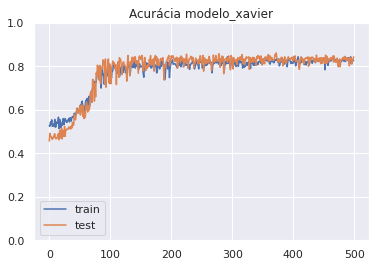

In [20]:
# define modelo mais fundo com inicializador de pesos melhor
model = Sequential(name="modelo_xavier")
model.add(Dense(5, input_dim=2, activation='tanh',kernel_initializer="glorot_uniform", name="xavier_1"))
model.add(Dense(5, activation='tanh',kernel_initializer="glorot_uniform", name="xavier_2"))
model.add(Dense(5, activation='tanh',kernel_initializer="glorot_uniform", name="xavier_3"))
model.add(Dense(5, activation='tanh', kernel_initializer="glorot_uniform",name="xavier_4"))
model.add(Dense(5, activation='tanh',kernel_initializer="glorot_uniform", name="xavier_5"))
model.add(Dense(1, activation='sigmoid', kernel_initializer="glorot_uniform", name="xavier_output"))

run_model(model,log_to_tb=True)

## <font color='blue'>Questão 2 </font>
Inicialize o TensorBoard e cheque os histogramas e as distribuições dos valores dos gradientes das 2 redes, como eles se diferem de uma rede para outra? Preste atenção em particular para a diferença de amplitude dos seus valores. Que conclusão podemos tirar? Insira/cole imagens do TensorBoard para basear seus argumentos, pode ser uma simples captura de tela.

**Obs:** Você pode filtrar elementos ao escrever a tag "kernel_0_grads" como filtro para facilitar sua exploração dos gradientes dos pesos excluindo os termos de bias/viés.

**Obs2:** Lembre-se de apagar a pasta `logs` se você for retreinar alguma das redes, caso contrário ele irá dar um append nos seus 2 treinamentos e seus graficos de loss e acurácia ficarão errados com loops ligando o começo de um treinamento ao final do outro.

**<font color='red'> Sua resposta aqui </font>**

A variância dos valores de gradientes na funda é de mais de 1 ordem de grandeza que a xavier, vide os gráficos abaixo (utilizei as camadas mais representativas).


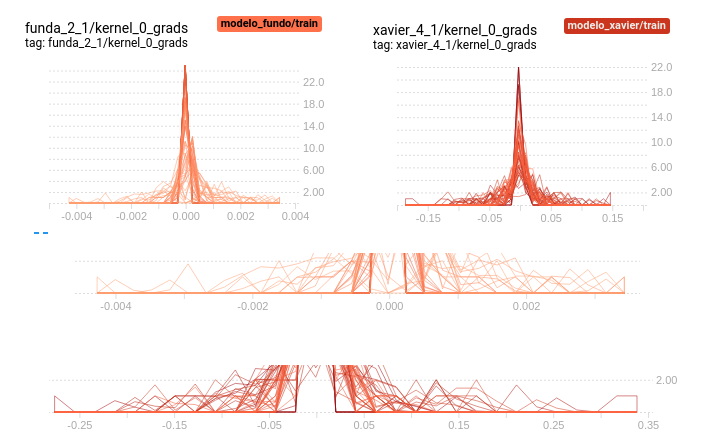

Os valores absolutos entre as rede

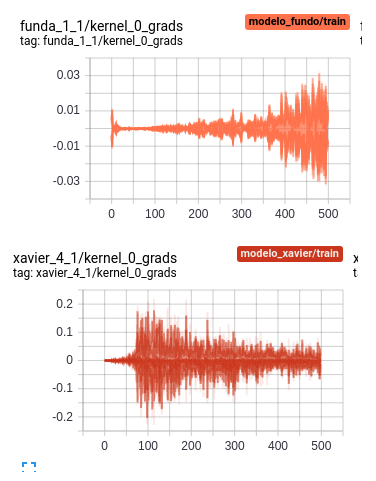